# Value-based agent in the cart-pole environment using PyTorch

|        | TYPE             | VALUES | DESCRIPTION                                                                     |
|--------|------------------|--------|---------------------------------------------------------------------------------|
| Action | ndarray<br/>(1,) | {0, 1} | Direction to push cart.<br/>0: left<br/>1: right                                |
| Observation | ndarray<br/>(4,) | float  | 1. Cart position<br/>2. Cart velocity<br/>3. Pole angle<br/>4. Angular velocity |
| Reward |  | float | Reward is given for every step taken, including the termination step.<br/>Each step provides a reward of +1 |
| Termination &<br/>Truncation |  | boolean | Pole Angle exceeds ± 0.2095 rad<br/>Cart Position exceeds ± 2.4 (i.e., edge of the display)<br/>Episode length is greater than 500 |

In [1]:
import copy
import time
import torch
import imageio
import gymnasium as gym
import matplotlib.pyplot as plt

from agents.value_simple import DeepQ

In [2]:
environment = gym.make('CartPole-v1', render_mode="rgb_array")

### Training

#### Parameters

In [3]:
GAMES = 4500

GAMMA = 0.99

EXPLORATION_RATE = 1.0
EXPLORATION_DECAY = 0.995
EXPLORATION_MIN = 0.01

MINIBATCH = 64
TRAIN_EVERY = 10

MEMORY = 1500
RESET_Q_EVERY = 250

NETWORK = {"inputs": 4, "outputs": 2, "nodes": [15, 30]}
OPTIMIZER = {"optim": torch.optim.RMSprop, "lr": 0.0025}

#### Initialisation

In [4]:
value_agent = DeepQ(
    network=NETWORK, optimizer=OPTIMIZER,
    gamma=GAMMA, batch_size=MINIBATCH, memory=MEMORY,
    exploration_rate=EXPLORATION_RATE, exploration_decay=EXPLORATION_DECAY, exploration_min=EXPLORATION_MIN
)

_value_agent = copy.deepcopy(value_agent)

In [5]:
checkpoint = GAMES // 10
metrics = {
    "steps": torch.zeros(GAMES),
    "losses": torch.zeros(GAMES // TRAIN_EVERY),
    "exploration": torch.zeros(GAMES)
}

#### Training

In [6]:
start = time.time()
for game in range(1, GAMES + 1):
    
    state = torch.tensor(environment.reset()[0], dtype=torch.float32).unsqueeze(0)            # noqa
    terminated = truncated = False
    
    # LEARNING FROM GAME
    # ----------------------------------------------------------------------------------------------
    
    steps = 0
    while not (terminated or truncated):
        steps += 1
        action = value_agent.action(state)
        new_state, reward, terminated, truncated, _ = environment.step(action.item())
        new_state = torch.tensor(new_state, dtype=torch.float32).unsqueeze(0)
        
        value_agent.remember(state, action, new_state, torch.tensor([reward]))
        state = new_state
    value_agent.memorize(steps)
    
    if game % TRAIN_EVERY == 0:
        loss = value_agent.learn(network=_value_agent)
        metrics["losses"][game // TRAIN_EVERY - 1] = loss
    
    if game % RESET_Q_EVERY == 0:
        _value_agent.load_state_dict(value_agent.state_dict())

    # METRICS
    # ----------------------------------------------------------------------------------------------
    
    metrics["steps"][game-1] = steps
    metrics["exploration"][game-1] = value_agent.explore["rate"]
    
    if game % checkpoint == 0 or game == GAMES:
        _mean_steps = metrics["steps"][max(0, game-checkpoint-1):game-1].mean()
        _mean_loss = metrics["losses"][max(0, (game-checkpoint-1) // TRAIN_EVERY):game // TRAIN_EVERY].mean()
        
        print(f"Game {game:>6} {int(game/GAMES * 100):>16} % \n"
              f"{'-'*30} \n"
              f" > Average steps: {int(_mean_steps):>12} \n"
              f" > Average loss: {_mean_loss:>13.4f} \n ")
        
print(f"Total training time: {time.time()-start:.2f} seconds")

Game    450               10 % 
------------------------------ 
 > Average steps:           28 
 > Average loss:        6.6089 
 
Game    900               20 % 
------------------------------ 
 > Average steps:           47 
 > Average loss:        3.8972 
 
Game   1350               30 % 
------------------------------ 
 > Average steps:           91 
 > Average loss:        2.9446 
 
Game   1800               40 % 
------------------------------ 
 > Average steps:          165 
 > Average loss:        1.8774 
 
Game   2250               50 % 
------------------------------ 
 > Average steps:          275 
 > Average loss:        0.9500 
 
Game   2700               60 % 
------------------------------ 
 > Average steps:          349 
 > Average loss:        0.5517 
 
Game   3150               70 % 
------------------------------ 
 > Average steps:          373 
 > Average loss:        0.3684 
 
Game   3600               80 % 
------------------------------ 
 > Average steps:         

#### Visualisation

##### Metrics

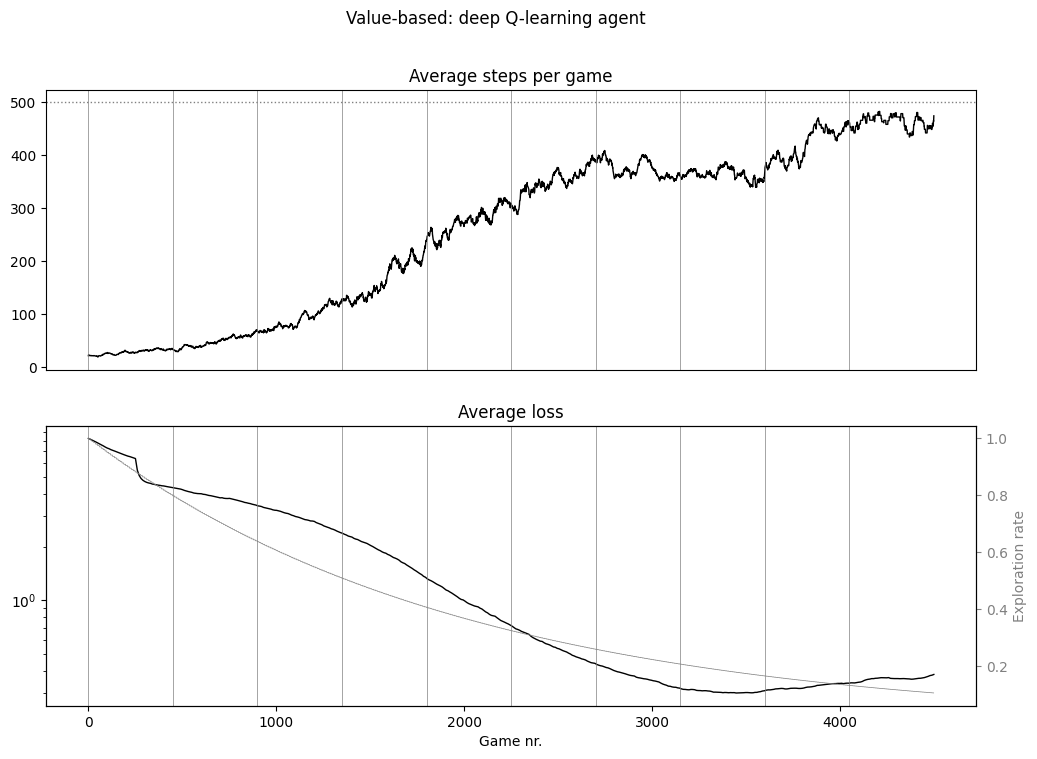

In [7]:
def moving_average(data, window_size=50):
    """Compute moving average with given window size of the data."""
    half_window = window_size // 2
    return [(data[max(0, i-half_window):min(len(data), i+half_window)]).mean() 
            for i in range(len(data))]

steps = moving_average(metrics["steps"])
losses = moving_average(metrics["losses"])

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
fig.suptitle("Value-based: deep Q-learning agent")

ax[0].axhline(y=500, color="gray", linestyle="dotted", linewidth=1)
ax[0].plot(steps, color="black", linewidth=1)
ax[0].set_xticks([])
ax[0].set_title("Average steps per game")

ax[1].plot(torch.linspace(0, GAMES, len(losses)), losses, color="black", linewidth=1)
ax[1].set_yscale("log")
ax[1].set_xlabel("Game nr.")
ax[1].set_title("Average loss")

ax_2 = ax[1].twinx()
ax_2.plot(metrics["exploration"], color="gray", linewidth=0.5)
ax_2.set_ylabel("Exploration rate")
ax_2.yaxis.label.set_color('gray')
ax_2.tick_params(axis='y', colors='gray')

for i in range(0, GAMES, GAMES // 10):
    ax[0].axvline(x=i, color='gray', linewidth=0.5)
    ax[1].axvline(x=i, color='gray', linewidth=0.5)

plt.savefig("./output/value-cartpole.png")
plt.show()

##### In action

In [8]:
state = torch.tensor(environment.reset()[0], dtype=torch.float32)

images = []
terminated = truncated = False
while not (terminated or truncated):
    action = torch.argmax(value_agent(state)).item()
    
    state, reward, terminated, truncated, _ = environment.step(action)
    state = torch.tensor(state, dtype=torch.float32)

    images.append(environment.render())
_ = imageio.mimsave('./output/value-cartpole.gif', images, duration=25)

<img src="./output/value-cartpole.gif" width="1000" height="1000" />

In [9]:
environment.close()